In [1]:
# inspired from: A deep understanding of deep learning



import numpy as np

import copy


import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset



import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# %matplotlib widget
%matplotlib notebook
%matplotlib inline


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = T.Compose([ T.ToTensor(),
                        T.RandomHorizontalFlip(p=.5),
                        T.Normalize(.5,.5),
                       ])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transform)
devtest  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

randidx = np.random.permutation(10000)   # a random permutation of indices
devset  = Subset(devtest,randidx[:6000]) # Subset for devset
testset = Subset(devtest,randidx[6000:]) # Subset for test

batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(devset,  batch_size=len(devset))
test_loader  = DataLoader(testset, batch_size=len(testset))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



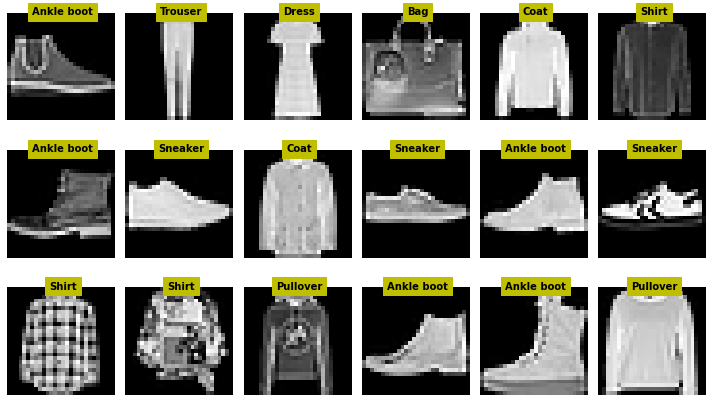

In [4]:
X,y = next(iter(test_loader))


fig,axs = plt.subplots(3,6,figsize=(10,6))

for (i,ax) in enumerate(axs.flatten()):

  pic = torch.squeeze(X.data[i])
  pic = pic/2 + .5 # undo normalization
  
  label = trainset.classes[y[i]]

  ax.imshow(pic,cmap='gray')
  ax.text(14,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [5]:
def makeTheAENet(printtoggle=False):

  class aenet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()
      
      self.print = printtoggle

      ### -------------- encoder layers -------------- ###
      # first convolution layer
      self.encconv1  = nn.Conv2d(1,16,3,padding=1,stride=2)
      # output size: (28+2*1-3)/2 + 1 = 14

      # second convolution layer
      self.encconv2  = nn.Conv2d(16,32,3,padding=1,stride=2)
      # output size: (14+2*1-3)/2 + 1 = 7
      

      ### -------------- decoder layers -------------- ###
      # first convolution layer
      self.decconv1  = nn.ConvTranspose2d(32,16,4,padding=1,stride=2)
      # output size: (28+2*1-3)/2 + 1 = 14

      # second convolution layer
      self.decconv2  = nn.ConvTranspose2d(16,1,4,padding=1,stride=2)
      # output size: (14+2*1-3)/2 + 1 = 7
      



    def forward(self,x):
      
      if self.print: print(f'Input: {list(x.shape)}')
      
      # first encoder layer
      x = F.leaky_relu(self.encconv1(x))
      if self.print: print(f'First encoder layer: {list(x.shape)}')

      # second encoder layer
      x = F.leaky_relu(self.encconv2(x))
      if self.print: print(f'Second encoder layer: {list(x.shape)}')

      # first decoder layer
      x = F.leaky_relu(self.decconv1(x))
      if self.print: print(f'First decoder layer: {list(x.shape)}')

      # second decoder layer
      x = F.leaky_relu(self.decconv2(x))
      if self.print: print(f'Second decoder layer: {list(x.shape)}')

      
      return x




  net = aenet(printtoggle)
  
  lossfun = nn.MSELoss()

  optimizer = torch.optim.Adam(net.parameters(),lr=.001)



  return net,lossfun,optimizer

  

In [6]:
tmpnet,lossfun,optimizer = makeTheAENet(True)

X,y = iter(train_loader).next()
yHat = tmpnet(X)

print('\nOutput size:')
print(yHat.shape)

loss = lossfun(yHat,X)
print(' ')
print('Loss:')
print(loss)

Input: [32, 1, 28, 28]
First encoder layer: [32, 16, 14, 14]
Second encoder layer: [32, 32, 7, 7]
First decoder layer: [32, 16, 14, 14]
Second decoder layer: [32, 1, 28, 28]

Output size:
torch.Size([32, 1, 28, 28])
 
Loss:
tensor(0.7014, grad_fn=<MseLossBackward0>)


In [7]:
def function2trainTheAEModel():

  numepochs = 10
  
  net,lossfun,optimizer = makeTheAENet()

  net.to(device)

  trainLoss = torch.zeros(numepochs)
  devLoss   = torch.zeros(numepochs)


  for epochi in range(numepochs):

    net.train()
    batchLoss = []
    for X,y in train_loader:

      X = X.to(device)
      y = y.to(device)

      yHat = net(X)
      loss = lossfun(yHat,X)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())

    trainLoss[epochi] = np.mean(batchLoss)



    #### test performance
    net.eval()
    X,y = next(iter(dev_loader))

    X = X.to(device)
    y = y.to(device)

    with torch.no_grad():
      yHat = net(X)
      loss = lossfun(yHat,X)

    devLoss[epochi] = loss.item()


  
  return trainLoss,devLoss,net



In [8]:
# ~3 minutes with 10 epochs on GPU
trainLoss,devLoss,aenet = function2trainTheAEModel()

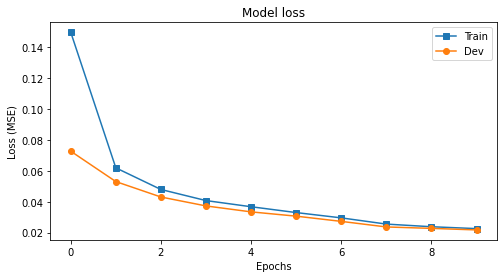

In [9]:
fig = plt.figure(figsize=(8,4))

plt.plot(trainLoss,'s-',label='Train')
plt.plot(devLoss,'o-',label='Dev')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss')
plt.legend()

plt.show()

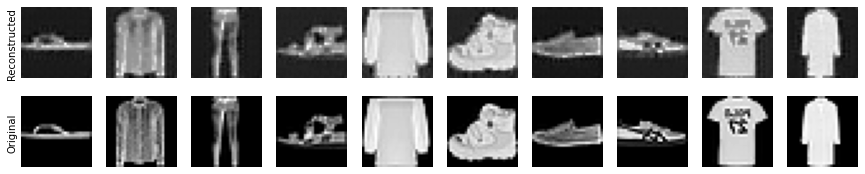

In [10]:
X,y = next(iter(dev_loader))


aenet.cpu()

aenet.eval()
yHat = aenet(X)



fig,axs = plt.subplots(2,10,figsize=(15,3))

for i in range(10):
  pic = yHat[i,0,:,:].detach()
  pic = pic/2 + .5 # undo normalization
  axs[0,i].imshow(pic,cmap='gray')
  axs[0,i].axis('off')

  pic = X[i,0,:,:].detach()
  pic = pic/2 + .5 # undo normalization
  axs[1,i].imshow(pic,cmap='gray')
  axs[1,i].axis('off')

  if i==0:
    axs[0,0].text(-6,14,'Reconstructed',rotation=90,va='center')
    axs[1,0].text(-6,14,'Original',rotation=90,va='center')

  
plt.show()

In [11]:
def makeTheClassNet(printtoggle=False):

  class cnnnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()
      
      self.print = printtoggle

      ### -------------- encoder layers -------------- ###
      # first convolution layer
      self.encconv1  = nn.Conv2d(1,16,3,padding=1,stride=2)
      # output size: (28+2*1-3)/2 + 1 = 14

      # second convolution layer
      self.encconv2  = nn.Conv2d(16,32,3,padding=1,stride=2)
      # output size: (14+2*1-3)/2 + 1 = 7
      

      ### ------------- linear layers ------------- ###
      self.fc1  = nn.Linear(7*7*32,50)
      self.fc2  = nn.Linear(50,10)
      



    def forward(self,x):
      
      if self.print: print(f'Input: {list(x.shape)}')
      
      # first encoder layer
      x = F.leaky_relu(self.encconv1(x))
      if self.print: print(f'First encoder layer: {list(x.shape)}')

      # second encoder layer
      x = F.leaky_relu(self.encconv2(x))
      if self.print: print(f'Second encoder layer: {list(x.shape)}')

      # reshape to linear
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Post-convolution vectorized: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      if self.print: print(f'First linear layer: {list(x.shape)}')

      x = F.leaky_relu(self.fc2(x))
      if self.print: print(f'Second linear layer: {list(x.shape)}')


      return x





  net = cnnnet(printtoggle)
  
  lossfun = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(net.parameters(),lr=.001)




  return net,lossfun,optimizer



In [12]:
tmpnet,lossfun,optimizer = makeTheClassNet(True)

X,y = iter(train_loader).next()
yHat = tmpnet(X)

print('\nOutput size:')
print(yHat.shape)

loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

Input: [32, 1, 28, 28]
First encoder layer: [32, 16, 14, 14]
Second encoder layer: [32, 32, 7, 7]
Post-convolution vectorized: [32, 1568]
First linear layer: [32, 50]
Second linear layer: [32, 10]

Output size:
torch.Size([32, 10])
 
Loss:
tensor(2.2946, grad_fn=<NllLossBackward0>)


In [13]:
def function2trainTheClassModel(net,lossfun,optimizer):

  numepochs = 10
  
  net.to(device)

  trainLoss = torch.zeros(numepochs)
  devLoss   = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  devAcc    = torch.zeros(numepochs)


  for epochi in range(numepochs):

    net.train()
    batchLoss = []
    batchAcc  = []


    for X,y in train_loader:

      X = X.to(device)
      y = y.to(device)

      yHat = net(X)
      loss = lossfun(yHat,y)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )

    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)



    #### test performance
    net.eval() # switch to test mode
    X,y = next(iter(dev_loader))

    X = X.to(device)
    y = y.to(device)

    with torch.no_grad():
      yHat = net(X)
      loss = lossfun(yHat,y)

    devLoss[epochi] = loss.item()
    devAcc[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()



  
  return trainLoss,devLoss,trainAcc,devAcc,net




In [14]:
# train a new model from scratch (not pre-trained!)

# create a naive network
naivenet,lossfun,optimizer = makeTheClassNet()

# train it from scratch
trainLossNaive,devLossNaive,trainAccNaive,devAccNaive,naivenet = function2trainTheClassModel(naivenet,lossfun,optimizer)


## evaluate on the test set
naivenet.eval()
X,y = next(iter(test_loader))

X = X.to(device)
y = y.to(device)

with torch.no_grad():
  yHat = naivenet(X)
  loss = lossfun(yHat,y)

# loss and accuracy from this batch
testLossNaive = loss.item()
testAccNaive  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

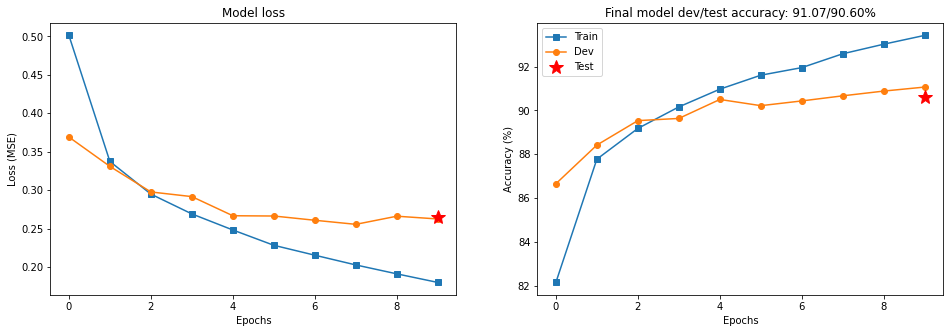

In [15]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLossNaive,'s-',label='Train')
ax[0].plot(devLossNaive,'o-',label='Dev')
ax[0].plot(len(devLossNaive)-1,testLossNaive,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAccNaive,'s-',label='Train')
ax[1].plot(devAccNaive,'o-',label='Dev')
ax[1].plot(len(devAccNaive)-1,testAccNaive,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {devAccNaive[-1]:.2f}/{testAccNaive:.2f}%')
ax[1].legend()

plt.show()

In [16]:
pretrainNet,lossfun,optimizer = makeTheClassNet()


for target,source in zip(pretrainNet.named_parameters(),aenet.named_parameters()):
  print('PRETRAIN: ' + target[0] + '  AENET: ' + source[0])

  if 'enc' in target[0]:
    target[1].data = copy.deepcopy( source[1].data )




PRETRAIN: encconv1.weight  AENET: encconv1.weight
PRETRAIN: encconv1.bias  AENET: encconv1.bias
PRETRAIN: encconv2.weight  AENET: encconv2.weight
PRETRAIN: encconv2.bias  AENET: encconv2.bias
PRETRAIN: fc1.weight  AENET: decconv1.weight
PRETRAIN: fc1.bias  AENET: decconv1.bias
PRETRAIN: fc2.weight  AENET: decconv2.weight
PRETRAIN: fc2.bias  AENET: decconv2.bias


In [17]:
# train the pretrained model

trainLossPre,devLossPre,trainAccPre,devAccPre,pretrainNet = function2trainTheClassModel(pretrainNet,lossfun,optimizer)


## evaluate on the test set
pretrainNet.eval()
X,y = next(iter(test_loader))

X = X.to(device)
y = y.to(device)

with torch.no_grad():
  yHat = pretrainNet(X)
  loss = lossfun(yHat,y)

testLossPre = loss.item()
testAccPre  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

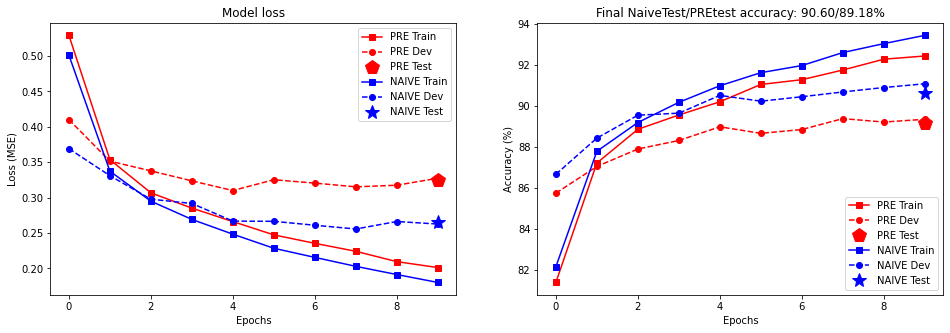

In [18]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLossPre,'rs-',label='PRE Train')
ax[0].plot(devLossPre,'ro--',label='PRE Dev')
ax[0].plot(len(devLossPre)-1,testLossPre,'rp',markersize=15,label='PRE Test')
ax[0].plot(trainLossNaive,'bs-',label='NAIVE Train')
ax[0].plot(devLossNaive,'bo--',label='NAIVE Dev')
ax[0].plot(len(devLossNaive)-1,testLossNaive,'b*',markersize=15,label='NAIVE Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAccPre,'rs-',label='PRE Train')
ax[1].plot(devAccPre,'ro--',label='PRE Dev')
ax[1].plot(len(devAccPre)-1,testAccPre,'rp',markersize=15,label='PRE Test')
ax[1].plot(trainAccNaive,'bs-',label='NAIVE Train')
ax[1].plot(devAccNaive,'bo--',label='NAIVE Dev')
ax[1].plot(len(devAccNaive)-1,testAccNaive,'b*',markersize=15,label='NAIVE Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final NaiveTest/PREtest accuracy: {testAccNaive:.2f}/{testAccPre:.2f}%')
ax[1].legend()

plt.show()

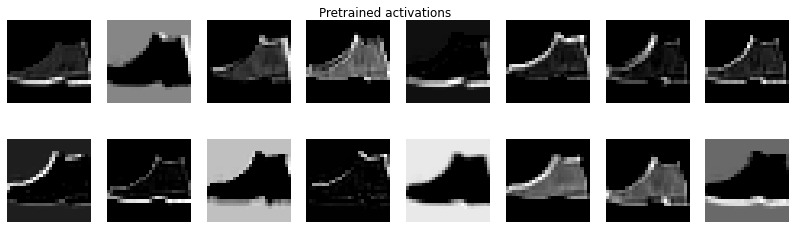

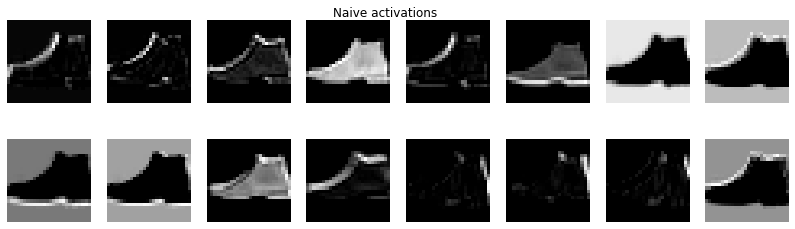

In [19]:
x = X[10,:,:,:].view(1,1,28,28)

# compute the activations of the first layer (excluding the bias b/c this is simply a constant)
layer1ActPre = F.relu( F.conv2d(x,pretrainNet.encconv1.weight) )
layer1ActNai = F.relu( F.conv2d(x,naivenet.encconv1.weight) )



## show the feature map activations for the pretrained model
fig,axs = plt.subplots(2,8,figsize=(14,4))
for i,ax in enumerate(axs.flatten()):
  act = torch.squeeze(layer1ActPre[0,i,:,:]).detach().cpu()
  ax.imshow(act,cmap='gray')
  ax.axis('off')

plt.suptitle('Pretrained activations',y=.9)
plt.show()



## show the feature map activations for the naive model
fig,axs = plt.subplots(2,8,figsize=(14,4))
for i,ax in enumerate(axs.flatten()):
  act = torch.squeeze(layer1ActNai[0,i,:,:]).detach().cpu()
  ax.imshow(act,cmap='gray')
  ax.axis('off')

plt.suptitle('Naive activations',y=.9)
plt.show()